# Fingerprint Testing

The purpose of this notebook is to test and calculate the ROC of the **train set**, just to figure out the best way to do so. It will follow a notebook with a proper test set.

In [2]:
import re

import numpy as np
import pandas as pd

In [3]:
string_df = pd.read_csv("../../data/interim/string_df.csv")

In [4]:
string_df

,label,concatenated
0,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
1,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
2,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
3,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
4,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
...,...,...
951,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
952,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
953,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
954,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...


In [5]:
balanced_pairs_df = pd.read_csv("../../data/interim/balanced_pairs_df.csv", index_col=0)
balanced_pairs_df.reset_index(drop=True, inplace=True)

In [6]:
balanced_pairs_df

,Item 1,Item 2,Equality,device1,device2
0,767,858,1,XiaomiRedmi5_J,XiaomiRedmi5_J
1,767,858,1,XiaomiRedmi5_J,XiaomiRedmi5_J
2,672,789,1,XiaomiRedmi5_J,XiaomiRedmi5_J
3,672,789,1,XiaomiRedmi5_J,XiaomiRedmi5_J
4,748,761,1,XiaomiRedmi5_J,XiaomiRedmi5_J
...,...,...,...,...,...
4995,326,330,-1,iPhone11_M,iPhoneXSMax_M
4996,33,442,-1,iPhone12_W,iPhone11_M
4997,120,832,-1,iPhone11_M,XiaomiRedmiNote7_S
4998,274,774,-1,iPhone11_M,XiaomiRedmi5_J


In [7]:
balanced_pairs_df.drop_duplicates(inplace=True)

Best filters, selected by BAMBOO algorithm

In [8]:
best_filters = [
    "0[2176] 🀆🀆🀆🀆🀫🀫🀫🀫 0[104]",
    "0[1944] 🀫🀫🀫🀫🀫🀫🀫🀫 0[336]",
    "0[0] 🀆🀆🀆🀆🀫🀫🀫🀫 0[2280]",
    "0[1720] 🀫🀫🀫🀫🀆🀆🀆🀆 0[560]",
    "0[1608] 🀆🀆🀆🀆🀫🀫🀫🀫 0[672]",
    "0[1600] 🀫🀫🀫🀫🀫🀫🀫🀫 0[680]",
    "0[1600] 🀫🀫🀫🀫🀆🀆🀆🀆 0[680]",
    "0[1600] 🀆🀆🀆🀆🀫🀫🀫🀫 0[680]",
    "0[1256] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1024]",
    "0[1720] 🀆🀆🀆🀆🀫🀫🀫🀫 0[560]",
    "0[1480] 🀫🀫🀫🀫🀆🀆🀆🀆 0[800]",
    "0[912] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1368]",
    "0[1136] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1144]",
    "0[1368] 🀆🀆🀆🀆🀫🀫🀫🀫 0[912]",
    "0[680] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1600]",
    "0[1136] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1144]",
    "0[1248] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1032]",
    "0[224] 🀫🀫🀫🀫🀫🀫🀫🀫 0[2056]",
    "0[1592] 🀫🀫🀫🀫🀆🀆🀆🀆 0[688]",
    "0[560] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1720]",
    "0[2064] 🀫🀫🀫🀫🀆🀆🀆🀆 0[216]",
    "0[1480] 🀫🀫🀫🀫🀫🀫🀫🀫 0[800]",
    "0[2064] 🀆🀆🀆🀆🀫🀫🀫🀫 0[216]",
    "0[2176] 🀫🀫🀫🀫🀆🀆🀆🀆 0[104]",
    "0[1608] 🀫🀫🀫🀫🀫🀫🀫🀫 0[672]",
    "0[1832] 🀫🀫🀫🀫🀫🀫🀫🀫 0[448]",
    "0[1720] 🀫🀫🀫🀫🀫🀫🀫🀫 0[560]",
    "0[1472] 🀫🀫🀫🀫🀫🀫🀫🀫 0[808]",
    "0[1128] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1152]",
    "0[1832] 🀫🀫🀫🀫🀆🀆🀆🀆 0[448]",
    "0[1584] 🀫🀫🀫🀫🀫🀫🀫🀫 0[696]",
    "0[1240] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1040]",
    "0[1832] 🀆🀆🀆🀆🀫🀫🀫🀫 0[448]",
    "0[1120] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1160]",
    "0[672] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1608]",
    "0[1112] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1168]",
    "0[664] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1616]",
    "0[1112] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1168]",
    "0[1112] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1168]",
    "0[2176] 🀫🀫🀫🀫🀫🀫🀫🀫 0[104]",
    "0[2168] 🀫🀫🀫🀫🀫🀫🀫🀫 0[112]",
    "0[2168] 🀫🀫🀫🀫🀆🀆🀆🀆 0[112]",
    "0[2168] 🀆🀆🀆🀆🀫🀫🀫🀫 0[112]",
    "0[1824] 🀫🀫🀫🀫🀫🀫🀫🀫 0[456]",
    "0[2048] 🀫🀫🀫🀫🀫🀫🀫🀫 0[232]",
    "0[2048] 🀫🀫🀫🀫🀆🀆🀆🀆 0[232]",
    "0[2160] 🀫🀫🀫🀫🀫🀫🀫🀫 0[120]",
    "0[1936] 🀆🀆🀆🀆🀫🀫🀫🀫 0[344]",
    "0[1456] 🀫🀫🀫🀫🀫🀫🀫🀫 0[824]",
    "0[1456] 🀫🀫🀫🀫🀆🀆🀆🀆 0[824]",
    "0[1232] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1048]",
    "0[1224] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1056]",
    "0[1096] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1184]",
    "0[1096] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1184]",
    "0[1096] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1184]",
    "0[872] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1408]",
    "0[768] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1512]",
    "0[1696] 🀫🀫🀫🀫🀫🀫🀫🀫 0[584]",
    "0[872] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1408]",
    "0[2184] 🀆🀆🀆🀆🀫🀫🀫🀫 0[96]",
    "0[2160] 🀫🀫🀫🀫🀆🀆🀆🀆 0[120]",
    "0[2040] 🀫🀫🀫🀫🀫🀫🀫🀫 0[240]",
    "0[2160] 🀆🀆🀆🀆🀫🀫🀫🀫 0[120]",
    "0[1704] 🀆🀆🀆🀆🀫🀫🀫🀫 0[576]",
    "0[1576] 🀆🀆🀆🀆🀫🀫🀫🀫 0[704]",
    "0[1928] 🀫🀫🀫🀫🀆🀆🀆🀆 0[352]",
    "0[1928] 🀆🀆🀆🀆🀫🀫🀫🀫 0[352]",
    "0[1808] 🀫🀫🀫🀫🀆🀆🀆🀆 0[472]",
    "0[2152] 🀫🀫🀫🀫🀫🀫🀫🀫 0[128]",
    "0[984] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1296]",
    "0[872] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1408]",
    "0[1688] 🀆🀆🀆🀆🀫🀫🀫🀫 0[592]",
    "0[976] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1304]",
    "0[752] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1528]",
    "0[536] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1744]",
    "0[976] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1304]",
    "0[976] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1304]",
    "0[1336] 🀆🀆🀆🀆🀫🀫🀫🀫 0[944]",
    "0[1680] 🀫🀫🀫🀫🀫🀫🀫🀫 0[600]",
    "0[2184] 🀫🀫🀫🀫🀆🀆🀆🀆 0[96]",
    "0[2152] 🀫🀫🀫🀫🀆🀆🀆🀆 0[128]",
    "0[2152] 🀆🀆🀆🀆🀫🀫🀫🀫 0[128]",
    "0[2032] 🀫🀫🀫🀫🀆🀆🀆🀆 0[248]",
    "0[1688] 🀫🀫🀫🀫🀆🀆🀆🀆 0[592]",
    "0[2144] 🀫🀫🀫🀫🀫🀫🀫🀫 0[136]",
    "0[1680] 🀆🀆🀆🀆🀫🀫🀫🀫 0[600]",
    "0[2024] 🀫🀫🀫🀫🀫🀫🀫🀫 0[256]",
    "0[1328] 🀫🀫🀫🀫🀆🀆🀆🀆 0[952]",
    "0[1672] 🀫🀫🀫🀫🀆🀆🀆🀆 0[608]",
    "0[1080] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1200]",
    "0[1432] 🀫🀫🀫🀫🀆🀆🀆🀆 0[848]",
    "0[744] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1536]",
    "0[744] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1536]",
    "0[736] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1544]",
    "0[736] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1544]",
    "0[2144] 🀫🀫🀫🀫🀆🀆🀆🀆 0[136]",
    "0[1200] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1080]",
    "0[616] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1664]",
    "0[1320] 🀆🀆🀆🀆🀫🀫🀫🀫 0[960]",
    "0[2184] 🀫🀫🀫🀫🀫🀫🀫🀫 0[96]",
    "0[2144] 🀆🀆🀆🀆🀫🀫🀫🀫 0[136]",
    "0[2024] 🀆🀆🀆🀆🀫🀫🀫🀫 0[256]",
    "0[1800] 🀆🀆🀆🀆🀫🀫🀫🀫 0[480]",
    "0[1672] 🀆🀆🀆🀆🀫🀫🀫🀫 0[608]",
    "0[1544] 🀫🀫🀫🀫🀫🀫🀫🀫 0[736]",
    "0[1912] 🀆🀆🀆🀆🀫🀫🀫🀫 0[368]",
    "0[1424] 🀫🀫🀫🀫🀫🀫🀫🀫 0[856]",
    "0[2136] 🀫🀫🀫🀫🀫🀫🀫🀫 0[144]",
    "0[1536] 🀫🀫🀫🀫🀫🀫🀫🀫 0[744]",
    "0[1192] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1088]",
    "0[1312] 🀆🀆🀆🀆🀫🀫🀫🀫 0[968]",
    "0[1536] 🀫🀫🀫🀫🀆🀆🀆🀆 0[744]",
    "0[1304] 🀫🀫🀫🀫🀆🀆🀆🀆 0[976]",
    "0[1056] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1224]",
    "0[1416] 🀫🀫🀫🀫🀆🀆🀆🀆 0[864]",
    "0[608] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1672]",
    "0[304] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1976]",
    "0[400] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1880]",
    "0[0] 🀫🀫🀫🀫🀆🀆🀆🀆 0[2280]",
    "0[2192] 🀆🀆🀆🀆🀫🀫🀫🀫 0[88]",
    "0[2016] 🀫🀫🀫🀫🀫🀫🀫🀫 0[264]",
    "0[2136] 🀫🀫🀫🀫🀆🀆🀆🀆 0[144]",
    "0[1904] 🀫🀫🀫🀫🀆🀆🀆🀆 0[376]",
    "0[1664] 🀫🀫🀫🀫🀆🀆🀆🀆 0[616]",
    "0[1664] 🀆🀆🀆🀆🀫🀫🀫🀫 0[616]",
    "0[1416] 🀫🀫🀫🀫🀫🀫🀫🀫 0[864]",
    "0[1656] 🀫🀫🀫🀫🀫🀫🀫🀫 0[624]",
]

In [9]:
best_thresholds = 8 * np.ones(
    len(best_filters)
)  # 8 is the threshold shared among the selected filters

## Functions

In [10]:
def convert_string_to_array(numeric_string: str) -> np.ndarray:
    # Extract numbers from the square brackets
    numbers = list(map(int, re.findall(r"\[([0-9]+)\]", numeric_string)))

    # Extract symbols between the square brackets, strip leading/trailing whitespace
    symbols = re.search(r"\](.*?)\[", numeric_string).group(1).strip()

    # Replace symbols
    symbol_map = {"🀆": -1, "🀫": 1}
    converted_symbols = [symbol_map[char] for char in symbols if char in symbol_map]

    # Construct the final array
    prefix_zeros = [0] * numbers[0]
    suffix_zeros = [0] * numbers[1]
    final_array = np.array(prefix_zeros + converted_symbols + suffix_zeros)

    return final_array

In [11]:
def generate_fingerprint(
    probe_burst: str, selected_filters: list, selected_thresholds: list
) -> list:
    probe_burst = np.array(list(probe_burst)).astype(int)

    selected_filter_arrays = []

    for selected_filter in selected_filters:
        selected_filter_array = convert_string_to_array(selected_filter)
        selected_filter_arrays.append(selected_filter_array)

    sum_array = []
    for selected_filter_array in selected_filter_arrays:
        sum_array.append(np.sum(np.multiply(probe_burst, selected_filter_array)))

    return sum_array

# Test filter only

Just to understand if the filters can discriminate between different probe burst, i will just filter each probe of the train set (without considering pairs and without using the thresholds). I will then proceed by grouping by filtered array.

In [12]:
string_df.iloc[0, 1]

'000000000000010000000010000001000000101100010110000000000000000000000000000000000000100000001100000100100001100000100100001100000100100001100000011011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111000000000101000011110010000010000000000000100111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [13]:
fingerprints = []
for string in string_df["concatenated"]:
    fingerprint = generate_fingerprint(string, best_filters, best_thresholds)
    fingerprints.append(fingerprint)

In [14]:
string_df["fingerprint"] = fingerprints

In [15]:
string_df

,label,concatenated,fingerprint
0,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
951,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
952,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
953,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
954,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
len(string_df.loc[1, "fingerprint"])

127

In [17]:
import time

# time.sleep(100)

In [18]:
string_df["fingerprint"] = string_df["fingerprint"].apply(
    lambda x: "".join(map(str, x))
)

In [19]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

In [20]:
string_df["fingerprint_label"] = label_encoder.fit_transform(string_df["fingerprint"])

In [21]:
string_df["fingerprint_label"].nunique()

148

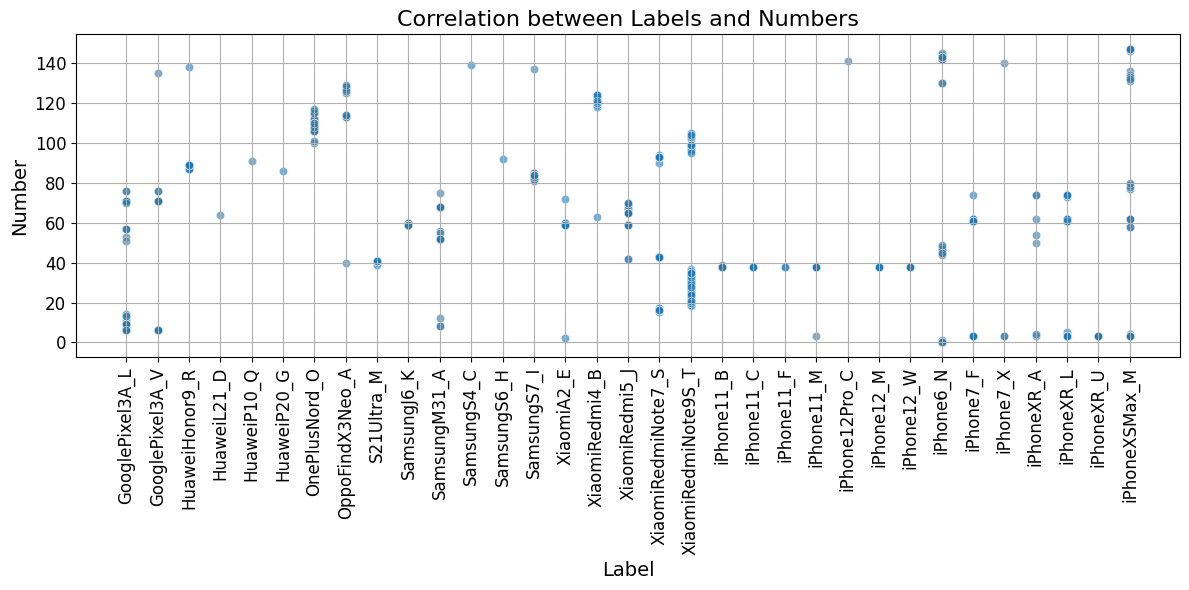

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation between labels and numbers
plt.figure(figsize=(12, 6))
sns.scatterplot(x="label", y="fingerprint_label", data=string_df, alpha=0.6)
plt.title("Correlation between Labels and Numbers", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Number", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
string_df[string_df["label"] == "iPhone6_N"]

,label,concatenated,fingerprint,fingerprint_label
758,iPhone6_N,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000-10600000000...,0
759,iPhone6_N,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000-10600000000...,0
760,iPhone6_N,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000-10600000000...,0
761,iPhone6_N,0000000000000100000000100000010000001011000101...,10000000000000000000000-10000000000-1060011-11...,46
762,iPhone6_N,0000000000000100000000100000010000001011000101...,30000000000000000000000-30000000000-1060032-22...,144
763,iPhone6_N,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000-10600000000...,0
764,iPhone6_N,0000000000000100000000100000010000001011000101...,30000000000000000000000-30000000000-1060032-22...,142
765,iPhone6_N,0000000000000100000000100000010000001011000101...,10000000000000000000000-10000000000-1060012-22...,48
766,iPhone6_N,0000000000000100000000100000010000001011000101...,30000000000000000000000-30000000000-1060032-22...,142
767,iPhone6_N,0000000000000100000000100000010000001011000101...,30000000000000000000000-30000000000-1060032-22...,143


## ROC

Per calcolare la ROC bisogna farlo sul dataset delle coppie, calcolare la $h$ come durante il training e poi utilizzare un threhsold $\tau$ per adatare la curva.

In [24]:
balanced_pairs_df

,Item 1,Item 2,Equality,device1,device2
0,767,858,1,XiaomiRedmi5_J,XiaomiRedmi5_J
2,672,789,1,XiaomiRedmi5_J,XiaomiRedmi5_J
4,748,761,1,XiaomiRedmi5_J,XiaomiRedmi5_J
6,745,778,1,XiaomiRedmi5_J,XiaomiRedmi5_J
8,731,734,1,XiaomiRedmi5_J,XiaomiRedmi5_J
...,...,...,...,...,...
4991,142,278,-1,iPhone11_M,XiaomiRedmiNote9S_T
4992,148,868,-1,iPhone11_M,HuaweiHonor9_R
4994,101,928,-1,iPhone11_M,XiaomiA2_E
4998,274,774,-1,iPhone11_M,XiaomiRedmi5_J


In [25]:
def convertColumntoArray(df: pd.DataFrame, column_name: str) -> np.array:
    return np.array([list(bstr) for bstr in df[column_name]])

In [26]:
def generateStringPairDf(pairs_df: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    # Convert the Probes column to a numpy array
    dataset_array = convertColumntoArray(dataset, "concatenated")

    return_df = pd.DataFrame()

    # Import the Probes into the pairs_df dataframe
    return_df["Item 1"] = pairs_df["Item 1"].apply(lambda index: dataset_array[index])
    return_df["Item 2"] = pairs_df["Item 2"].apply(lambda index: dataset_array[index])
    return_df["Equality"] = pairs_df["Equality"]

    return return_df

In [27]:
string_df

,label,concatenated,fingerprint,fingerprint_label
0,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000000000000000...,10
1,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,10000000000000000000000-100000000000000011-110...,76
2,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000000000000000...,11
3,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,10000000000000000000000-100000000000000011-110...,57
4,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000000000000000...,9
...,...,...,...,...
951,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000000000000000...,3
952,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000000000000000...,3
953,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,0000000000000000000000000000000000000000000000...,3
954,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,10000000000000000000000-100000000000000011-110...,62


In [28]:
matrix_df = generateStringPairDf(balanced_pairs_df, string_df)

In [29]:
matrix_df

,Item 1,Item 2,Equality
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
...,...,...,...
4991,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1
4992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1
4994,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1
4998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1


In [79]:
matrix_df.reset_index(inplace=True, drop=True)

In [82]:
matrix_df.loc[3, "Item 1"]

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U1')

In [31]:
def filter_parser(input_string: str) -> list:
    # Split the string into its parts
    parts = input_string.split()

    # Initialize the final array
    result = []

    # Process each part
    for part in parts:
        if part.startswith("0["):
            # Extract the number inside the brackets
            count = int(part[2:-1])
            # Append the corresponding number of zeros to the result
            result.extend([0] * count)
        else:
            # Translate the tiles to their respective values
            for char in part:
                if char == "🀆":
                    result.append(-1)
                elif char == "🀫":
                    result.append(1)

    return result

In [58]:
def apply_filter(item, filter):
    item = np.array(list(item)).astype(int)
    filter = filter_parser(filter)
    return np.sum(np.multiply(item, filter))

In [78]:
matrix_df.loc[4, "Item 1"]

array(['0', '0', '0', ..., '0', '0', '1'], dtype='<U1')

In [91]:
apply_filter(matrix_df.loc[43, "Item 1"], best_filters[43])

0

In [62]:
def apply_filter_threshold(item, filter, threshold) -> int:
    if apply_filter(item, filter) > threshold:
        return 1
    else:
        return -1

In [63]:
apply_filter_threshold(matrix_df.loc[0, "Item 1"], best_filters[0], best_thresholds[0])

-1

In [98]:
for i in range(1000):
    print(apply_filter_threshold(matrix_df.loc[i, "Item 1"], best_filters[0], 1))

1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1

In [41]:
apply_filter_threshold(
    matrix_df.loc[1414, "Item 2"], best_filters[0], best_thresholds[0]
)

-1

In [37]:
def apply_filter_threshold_pair(item_1, item_2, filter, threshold) -> int:
    if apply_filter_threshold(item_1, filter, threshold) == apply_filter_threshold(
        item_2, filter, threshold
    ):
        return 1
    else:
        return -1

This is the prediction

In [39]:
apply_filter_threshold_pair(
    matrix_df.loc[0, "Item 1"],
    matrix_df.loc[0, "Item 2"],
    best_filters[0],
    best_thresholds[0],
)

1

In [38]:
time.sleep(100)

KeyboardInterrupt: 

$\sum \text{xor} (F_1, F_2) < T$ -> +1 otherwise -1

$0 < T < M$

Sbagliato: la fingerprint si fa di una coppia di probe, non di una sola

In [ ]:
def calculate_fingerprint(item_1, item_2, best_filters, best_thresholds):
    fingerprint = []

    for best_filter in best_filters:
        fingerprint.append(
            apply_filter_threshold_pair(item_1, item_2, best_filter, best_thresholds)
        )

    return fingerprint

In [ ]:
matrix_df.loc[0, "Item 1"]

array(['0', '0', '0', ..., '1', '0', '0'], dtype='<U1')

In [ ]:
calculate_fingerprint(
    matrix_df.loc[1500, "Item 1"], matrix_df.loc[1500, "Item 2"], best_filters, 8
)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
# hamming_distance(
#     calculate_fingerprint(matrix_df.loc[0, "Item 1"], best_filters, best_thresholds),
#     calculate_fingerprint(matrix_df.loc[0, "Item 2"], best_filters, best_thresholds),
# )

In [ ]:
for i, row in matrix_df.iterrows():
    fingerprint_1 = []
    fingerprint_2 = []
    ground_truth = row["Equality"]

    # for best_filter, best_threshold in zip(best_filters, best_thresholds):
    #     #     fingerprint_1.append(
    #     #         sum(row["Item 1"].astype(int) * filter_parser(best_filter)) - best_threshold
    #     #     )
    #     #     fingerprint_2.append(
    #     #         sum(row["Item 2"].astype(int) * filter_parser(best_filter)) - best_threshold
    #     #     )

    #     # fingerprint = calculate_fingerprint(
    #     #     row["Item 1"], row["Item 2"], best_filters, best_thresholds
    #     # )

    #     matrix_df.at[i, "prediction"] = apply_filter_threshold_pair(
    #         row["Item 1"], row["Item 2"], best_filter, best_threshold
    #     )

    matrix_df.at[i, "distance"] = calculate_fingerprint(
        row["Item 1"], row["Item 2"], best_filters, best_thresholds[0]
    )

In [ ]:
matrix_df

,Item 1,Item 2,Equality,prediction
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
...,...,...,...,...
4991,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0
4992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0
4994,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0
4998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0


In [ ]:
matrix_df

,Item 1,Item 2,Equality,prediction
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0
...,...,...,...,...
3553,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0
3554,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0
3555,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0
3556,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0


In [ ]:
position = 1425

prediction = apply_filter_threshold_pair(
    matrix_df.loc[position, "Item 1"],
    matrix_df.loc[position, "Item 2"],
    best_filters[0],
    best_thresholds[0],
)

print(prediction)
print(matrix_df.loc[position, "Equality"])

0.0
-1


In [ ]:
taus = [1, 16, 20, 24, 32, 48, 64, 128]

In [ ]:
for tau in taus:
    matrix_df[f"prediction_{tau}"] = np.where(matrix_df["h_distance"] < tau, 1, -1)

KeyError: 'h_distance'

In [ ]:
matrix_df

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming matrix_df is your DataFrame
# True labels
y_true = matrix_df["Equality"]

plt.figure()

# Loop through each prediction column
for column in matrix_df.columns:
    if column.startswith("prediction_"):
        # Predicted scores
        y_scores = matrix_df[column]

        # Compute ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = roc_auc_score(y_true, y_scores)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f"{column} (area = %0.2f)" % roc_auc)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [103]:
import numpy as np

# Example arrays
M_f_xa_t = np.array([1, -1, 0, 1, 0])
M_f_xb_t = np.array([1, -1, -1, 1, -1])

# Calculate element-wise product
product = M_f_xa_t * M_f_xb_t

# Generate array with +1 where elements match and -1 otherwise
result_array = np.where(product == 1, 1, -1)

print("M_f_xa_t:\t", M_f_xa_t)
print("M_f_xb_t:\t", M_f_xb_t)
print("Product:\t", product)
print("Result Array:\t", result_array)

M_f_xa_t:	 [ 1 -1  0  1  0]
M_f_xb_t:	 [ 1 -1 -1  1 -1]
Product:	 [1 1 0 1 0]
Result Array:	 [ 1  1 -1  1 -1]
